<a href="https://colab.research.google.com/github/dauvannam1804/GCN-Keras/blob/main/GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://keras.io/examples/graph/gnn_citations/

**Setup**

In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**Prepare the Dataset**

The Cora dataset consists of 2,708 scientific papers classified into one of seven classes. The citation network consists of 5,429 links. Each paper has a binary word vector of size 1,433, indicating the presence of a corresponding word.

Download the dataset
The dataset has two tap-separated files: cora.cites and cora.content.

The cora.cites includes the citation records with two columns: cited_paper_id (target) and citing_paper_id (source).
The cora.content includes the paper content records with 1,435 columns: paper_id, subject, and 1,433 binary features.
Let's download the dataset.

In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

168052/168052 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Process and visualize the dataset**
Then we load the citations data into a Pandas DataFrame.

In [ ]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


Now we display a sample of the citations DataFrame. The target column includes the paper ids cited by the paper ids in the source column.

In [ ]:
citations.sample(frac=1).head()

,target,source
2033,15429,9515
4692,254923,108047
1300,6214,1130600
1504,7419,1107312
2320,20924,1115701


Now let's load the papers data into a Pandas DataFrame.

In [ ]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


Now we display a sample of the papers DataFrame. The DataFrame includes the paper_id and the subject columns, as well as 1,433 binary column representing whether a term exists in the paper or not.

In [ ]:
print(papers.sample(5).T)

                            2323                   347         2465  \
paper_id                 1152633                   3187     1102625   
term_0                         0                      0           0   
term_1                         0                      0           0   
term_2                         0                      0           0   
term_3                         0                      0           0   
...                          ...                    ...         ...   
term_1429                      0                      0           0   
term_1430                      0                      0           0   
term_1431                      0                      0           0   
term_1432                      0                      0           0   
subject    Probabilistic_Methods  Probabilistic_Methods  Case_Based   

                             2368    514   
paper_id                     6152  321861  
term_0                          0       0  
term_1         

Let's display the count of the papers in each subject.

In [ ]:
print(papers.subject.value_counts())

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


We convert the paper ids and the subjects into zero-based indices.

In [ ]:
class_values = sorted(papers["subject"].unique())
print(class_values)
class_idx = {name: id for id, name in enumerate(class_values)}
print(class_idx)
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}
print(paper_idx)

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

['Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory']
{'Case_Based': 0, 'Genetic_Algorithms': 1, 'Neural_Networks': 2, 'Probabilistic_Methods': 3, 'Reinforcement_Learning': 4, 'Rule_Learning': 5, 'Theory': 6}
{35: 0, 40: 1, 114: 2, 117: 3, 128: 4, 130: 5, 164: 6, 288: 7, 424: 8, 434: 9, 463: 10, 504: 11, 506: 12, 887: 13, 906: 14, 910: 15, 936: 16, 940: 17, 941: 18, 943: 19, 1026: 20, 1033: 21, 1034: 22, 1035: 23, 1213: 24, 1237: 25, 1246: 26, 1272: 27, 1365: 28, 1385: 29, 1481: 30, 1688: 31, 1694: 32, 1717: 33, 1786: 34, 1817: 35, 1919: 36, 1949: 37, 1951: 38, 1952: 39, 1953: 40, 1955: 41, 1956: 42, 1959: 43, 1997: 44, 1999: 45, 2354: 46, 2440: 47, 2653: 48, 2654: 49, 2658: 50, 2663: 51, 2665: 52, 2695: 53, 2696: 54, 2698: 55, 2702: 56, 3084: 57, 3085: 58, 3095: 59, 3097: 60, 3101: 61, 3112: 62, 3187: 63, 3191: 64, 3192: 65, 3217: 66, 3218: 67, 3220: 68, 3222: 69, 3223: 70, 3229: 71, 3231: 72, 3232: 73, 32

In [ ]:
papers

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,462,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
1,1911,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,5
2,2002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,519,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,2370,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2704,2371,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2705,2372,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2706,955,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
citations

,target,source
0,0,21
1,0,905
2,0,906
3,0,1909
4,0,1940
...,...,...
5424,1873,328
5425,1873,1876
5426,1874,2586
5427,1876,1874


Now let's visualize the citation graph. Each node in the graph represents a paper, and the color of the node corresponds to its subject. Note that we only show a sample of the papers in the dataset.



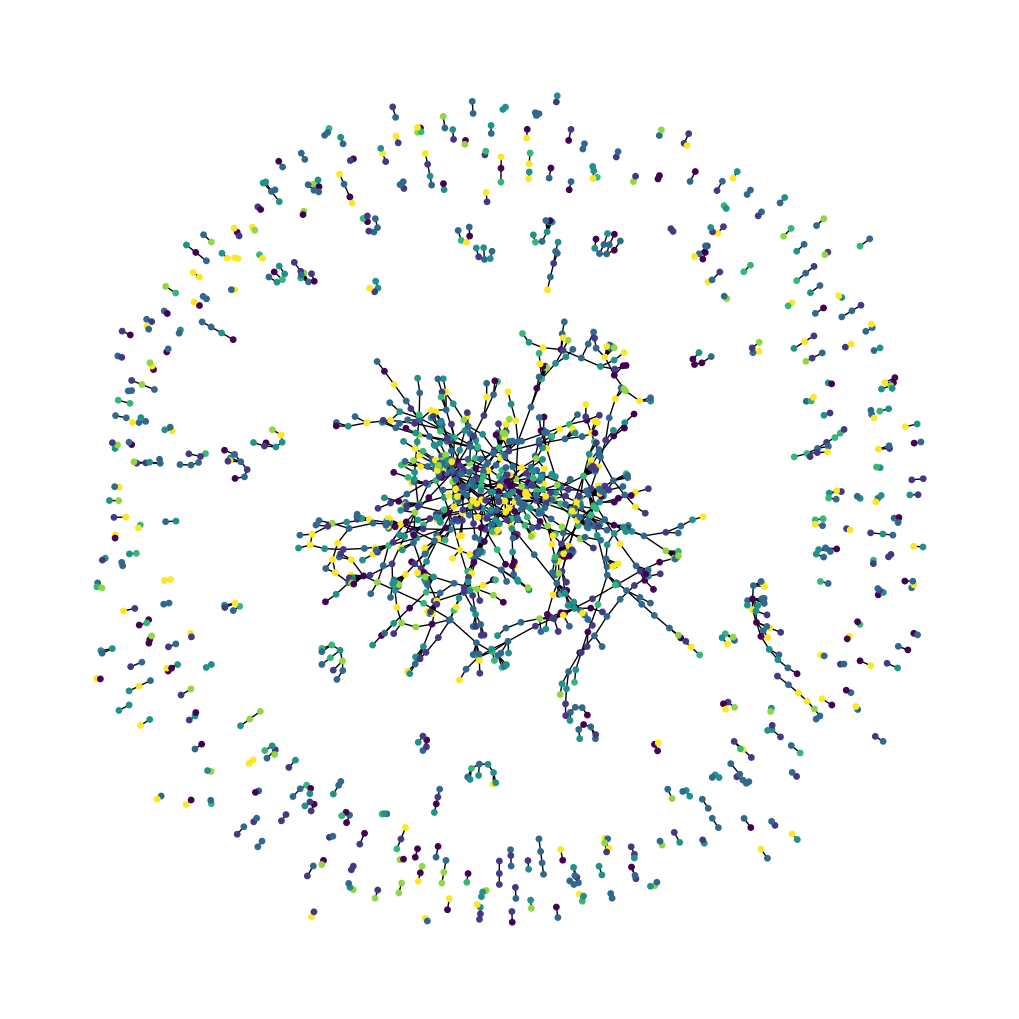

In [ ]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

Split the dataset into stratified train and test sets

In [ ]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1346, 1435)
Test data shape: (1362, 1435)


In [ ]:
train_data

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
686,131,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2211,1584,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
374,1973,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1970,2232,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
712,681,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962,2074,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
2671,2630,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1857,546,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3
2073,2064,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [ ]:
train_data.iloc[0]

,686
paper_id,131
term_0,0
term_1,0
term_2,0
term_3,0
...,...
term_1429,0
term_1430,0
term_1431,0
term_1432,0


In [ ]:
print((train_data.iloc[0] != 0).sum())

23


In [ ]:
train_data.iloc[0][train_data.iloc[0] != 0]

,686
paper_id,131
term_98,1
term_158,1
term_159,1
term_260,1
term_273,1
term_367,1
term_384,1
term_470,1
term_507,1


**Implement Train and Evaluate Experiment**

In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

This function compiles and trains an input model using the given training data.

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

This function displays the loss and accuracy curves of the model during training.

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

**Implement Feedforward Network (FFN) Module** <br>
We will use this module in the baseline and the GNN models.



In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

**Build a Baseline Neural Network Model** <br>
Prepare the data for the baseline model

In [ ]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"}) # term_0 -> term_1432
print(feature_names)
num_features = len(feature_names)
print(num_features)
num_classes = len(class_idx)
print(num_classes)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

['term_866', 'term_612', 'term_791', 'term_1310', 'term_1317', 'term_260', 'term_1420', 'term_514', 'term_1078', 'term_203', 'term_1371', 'term_453', 'term_1343', 'term_633', 'term_571', 'term_615', 'term_357', 'term_590', 'term_1320', 'term_598', 'term_80', 'term_273', 'term_1142', 'term_579', 'term_212', 'term_144', 'term_555', 'term_442', 'term_1394', 'term_591', 'term_725', 'term_1404', 'term_757', 'term_853', 'term_577', 'term_10', 'term_1348', 'term_61', 'term_744', 'term_384', 'term_981', 'term_553', 'term_1239', 'term_349', 'term_1058', 'term_1367', 'term_512', 'term_518', 'term_1169', 'term_1345', 'term_38', 'term_610', 'term_287', 'term_101', 'term_1263', 'term_188', 'term_64', 'term_908', 'term_973', 'term_921', 'term_120', 'term_485', 'term_963', 'term_834', 'term_1076', 'term_1179', 'term_343', 'term_619', 'term_200', 'term_1118', 'term_673', 'term_173', 'term_1376', 'term_617', 'term_158', 'term_328', 'term_928', 'term_626', 'term_91', 'term_1403', 'term_947', 'term_901',

In [ ]:
print(x_train[0])
print(len(x_train[0]))

print(y_train[0])

[0 0 0 ... 0 0 0]
1433
2


**Implement a baseline classifier** <br>
We add five FFN blocks with skip connections, so that we generatee a baseline model with roughly the same number of parameters as the GNN models to be built later.

In [ ]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_features            │ (None, 1433)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block1 (Sequential)   │ (None, 32)             │         52,804 │ input_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block2 (Sequential)   │ (None, 32)             │          2,368 │ ffn_block1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection2 (Add)    │ (None, 32)             │              0 │ ffn_block1[0][0],      │
│                           │                        │                │ ffn_block2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block3 (Sequential)   │ (None, 32)             │          2,368 │ skip_connection2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection3 (Add)    │ (None, 32)             │              0 │ skip_connection2[0][0… │
│                           │                        │                │ ffn_block3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block4 (Sequential)   │ (None, 32)             │          2,368 │ skip_connection3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection4 (Add)    │ (None, 32)             │              0 │ skip_connection3[0][0… │
│                           │                        │                │ ffn_block4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block5 (Sequential)   │ (None, 32)             │          2,368 │ skip_connection4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection5 (Add)    │ (None, 32)             │              0 │ skip_connection4[0][0… │
│                           │                        │                │ ffn_block5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ logits (Dense)            │ (None, 7)              │            231 │ skip_connection5[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 62,507 (244.17 KB)

 Trainable params: 59,065 (230.72 KB)

 Non-trainable params: 3,442 (13.45 KB)

**Train the baseline classifier**

In [ ]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - acc: 0.1148 - loss: 4.7374 - val_acc: 0.2970 - val_loss: 1.8414
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.2584 - loss: 2.6217 - val_acc: 0.2970 - val_loss: 1.8384
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.2939 - loss: 2.4613 - val_acc: 0.2970 - val_loss: 1.8319
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.2892 - loss: 2.0687 - val_acc: 0.3069 - val_loss: 1.8190
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.3098 - loss: 1.9719 - val_acc: 0.3267 - val_loss: 1.7975
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.3444 - loss: 1.8213 - val_acc: 0.3366 - val_loss: 1.7708
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.3723 - loss: 1.7475 - val_acc: 0.3663 - val_loss: 1.7444
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.4162 - loss: 1.6258 - val_acc: 0.4257 - val_loss: 1.7192
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - acc: 0.4360 - loss: 1

Let's plot the learning curves.



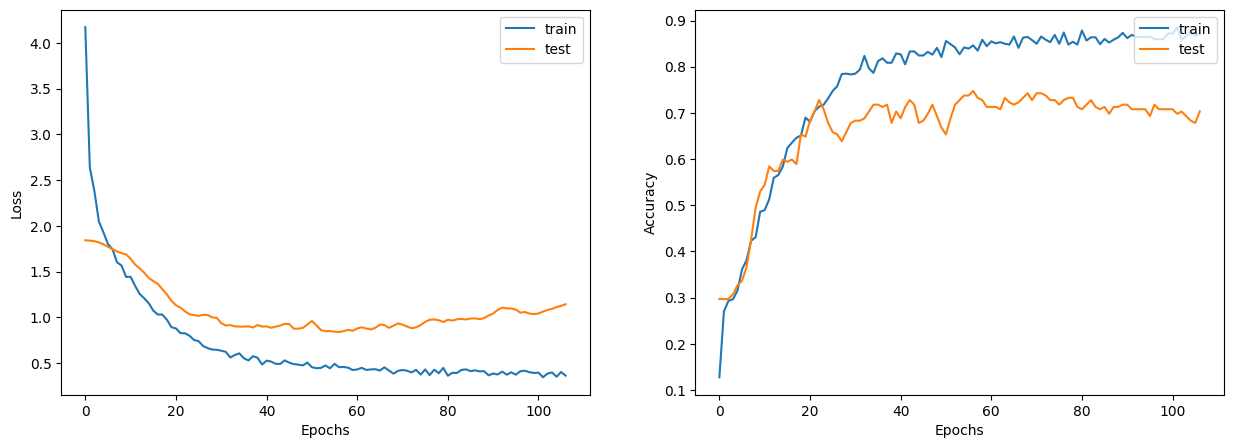

In [ ]:
display_learning_curves(history)

Now we evaluate the baseline model on the test data split.



In [ ]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 77.53%


**Examine the baseline model predictions** <br>
Let's create new data instances by randomly generating binary word vectors with respect to the word presence probabilities.

In [ ]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

Now we show the baseline model predictions given these randomly generated instances.



In [ ]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
Instance 1:
- Case_Based: 6.7%
- Genetic_Algorithms: 15.57%
- Neural_Networks: 18.11%
- Probabilistic_Methods: 1.23%
- Reinforcement_Learning: 15.46%
- Rule_Learning: 4.5%
- Theory: 38.44%
Instance 2:
- Case_Based: 1.41%
- Genetic_Algorithms: 20.6%
- Neural_Networks: 36.25%
- Probabilistic_Methods: 32.13%
- Reinforcement_Learning: 5.08%
- Rule_Learning: 0.99%
- Theory: 3.54%
Instance 3:
- Case_Based: 0.44%
- Genetic_Algorithms: 71.58%
- Neural_Networks: 17.29%
- Probabilistic_Methods: 2.68%
- Reinforcement_Learning: 6.4%
- Rule_Learning: 0.33%
- Theory: 1.29%
Instance 4:
- Case_Based: 0.61%
- Genetic_Algorithms: 24.74%
- Neural_Networks: 60.1%
- Probabilistic_Methods: 3.6%
- Reinforcement_Learning: 2.0%
- Rule_Learning: 1.64%
- Theory: 7.32%
Instance 5:
- Case_Based: 21.35%
- Genetic_Algorithms: 40.0%
- Neural_Networks: 11.52%
- Probabilistic_Methods: 8.22%
- Reinforcement_Learning: 3.55%
- Rule_Learning: 3.61%
- Theory: 11.74%
Instance 6:
- Case_

**Build a Graph Neural Network Model**

Prepare the data for the graph model

Preparing and loading the graphs data into the model for training is the most challenging part in GNN models, which is addressed in different ways by the specialised libraries. In this example, we show a simple approach for preparing and using graph data that is suitable if your dataset consists of a single graph that fits entirely in memory.

**The graph data is represented by the graph_info tuple, which consists of the following three elements:**

1. node_features: This is a [num_nodes, num_features] NumPy array that includes the node features. In this dataset, the nodes are the papers, and the node_features are the word-presence binary vectors of each paper.
2. edges: This is [num_edges, num_edges] NumPy array representing a sparse adjacency matrix of the links between the nodes. In this example, the links are the citations between the papers.
3. edge_weights (optional): This is a [num_edges] NumPy array that includes the edge weights, which quantify the relationships between nodes in the graph. In this example, there are no weights for the paper citations.


In [ ]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [ ]:
print(type(node_features))
print(node_features[0])

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([0. 0. 0. ... 0. 0. 1.], shape=(1433,), dtype=float32)


In [ ]:
print(type(edges))
print(edges[0])
print(edges)

<class 'numpy.ndarray'>
[  21  905  906 ... 2586 1874 2707]
[[  21  905  906 ... 2586 1874 2707]
 [   0    0    0 ... 1874 1876 1897]]


In [ ]:
print(type(edge_weights))
print(edge_weights)

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(5429,), dtype=float32)


Implement a graph convolution layer <br>
We implement a graph convolution module as a Keras Layer. Our GraphConvLayer performs the following steps:

**Prepare:** The input node representations are processed using a FFN to produce a message. You can simplify the processing by only applying linear transformation to the representations. <br>
**Aggregate:** The messages of the neighbours of each node are aggregated with respect to the edge_weights using a permutation invariant pooling operation, such as sum, mean, and max, to prepare a single aggregated message for each node. See, for example, tf.math.unsorted_segment_sum APIs used to aggregate neighbour messages. <br>
**Update:** The node_repesentations and aggregated_messages—both of shape [num_nodes, representation_dim]— are combined and processed to produce the new state of the node representations (node embeddings). If combination_type is gru, the node_repesentations and aggregated_messages are stacked to create a sequence, then processed by a GRU layer. Otherwise, the node_repesentations and aggregated_messages are added or concatenated, then processed using a FFN.<br>

The technique implemented use ideas from Graph Convolutional Networks, GraphSage, Graph Isomorphism Network, Simple Graph Networks, and Gated Graph Sequence Neural Networks. Two other key techniques that are not covered are Graph Attention Networks and Message Passing Neural Networks.

In [ ]:
def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
      x = layers.GRU(
          units=units,
          activation="tanh",
          recurrent_activation="sigmoid",
          return_sequences=True,
          dropout=dropout_rate,
          return_state=False,
          recurrent_dropout=dropout_rate,
      )(x)
    return keras.Model(inputs=inputs, outputs=x)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

**Implement a graph neural network node classifier** <br>

The GNN classification model follows the Design Space for Graph Neural Networks approach, as follows:

Apply preprocessing using FFN to the node features to generate initial node representations. <br>

Apply one or more graph convolutional layer, with skip connections, to the node representation to produce node embeddings. <br>

Apply post-processing using FFN to the node embeddings to generate the final node embeddings. <br>
Feed the node embeddings in a Softmax layer to predict the node class. <br>

Each graph convolutional layer added captures information from a further level of neighbours. However, adding many graph convolutional layer can cause oversmoothing, where the model produces similar embeddings for all the nodes.

**Note that** the graph_info passed to the constructor of the Keras model, and used as a property of the Keras model object, rather than input data for training or prediction. The model will accept a batch of node_indices, which are used to lookup the node features and neighbours from the graph_info.

In [ ]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


Let's test instantiating and calling the GNN model. Notice that if you provide N node indices, the output will be a tensor of shape [N, num_classes], regardless of the size of the graph.

In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

# print("GNN output shape:", gnn_model(tf.convert_to_tensor([1, 10, 100], dtype=tf.float32)))

gnn_model.summary()

Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv1 (GraphConvLayer)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv2 (GraphConvLayer)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ postprocess (Sequential)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ logits (Dense)                       │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Train the GNN model** <br>
Note that we use the standard supervised cross-entropy loss to train the model. However, we can add another self-supervised loss term for the generated node embeddings that makes sure that neighbouring nodes in graph have similar representations, while faraway nodes have dissimilar representations.

In [ ]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.2707 - loss: 1.8748 - val_acc: 0.3960 - val_loss: 1.7376
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.4288 - loss: 1.6597 - val_acc: 0.4802 - val_loss: 1.5138
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.6024 - loss: 1.2341 - val_acc: 0.5396 - val_loss: 1.2289
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.7239 - loss: 0.7615 - val_acc: 0.5941 - val_loss: 1.4419
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.8347 - loss: 0.4689 - val_acc: 0.6337 - val_loss: 1.4003
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.8869 - loss: 0.2968 - val_acc: 0.6535 - val_loss: 1.8091
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.9418 - loss: 0.1835 - val_acc: 0.6782 - val_loss: 1.9403
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.9834 - loss: 0.0538 - val_acc: 0.6683 - val_loss: 2.2551
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.9927 - loss: 0

Let's plot the learning curves

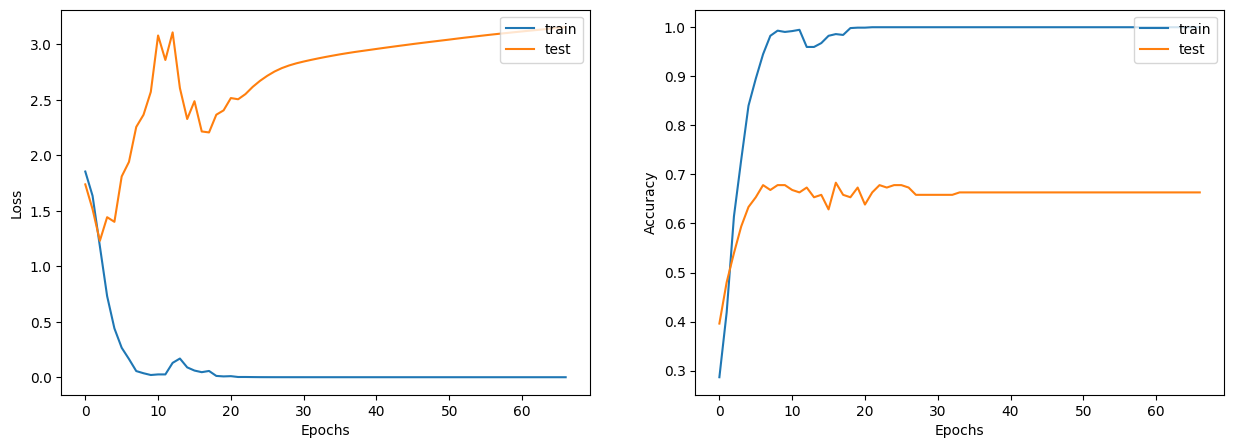

In [ ]:
display_learning_curves(history)

Now we evaluate the GNN model on the test data split. The results may vary depending on the training sample, however the GNN model always outperforms the baseline model in terms of the test accuracy.

In [ ]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 69.38%
